# Covid vs. Non-Covid CT scan classification

### ICCV 2021 Workshop: MIA-COV19D Competition
#### Mohammad Nayeem Teli

 ### Import libraries

In [22]:

import os
import numpy as np
import pandas as pd
import math

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model,models
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.preprocessing import image
import tensorflow_addons as tfa


from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


### Data directories and listing some files

In [2]:
base_dir = 'ICCV2021Data/COV19DCompetition/Data/'
train_dir = os.path.join(base_dir,'train1')
validation_dir = os.path.join(base_dir,'validation1')
test_dir = os.path.join(base_dir,'test')

In [3]:
# Directory with covid training images
train_covid_dir = os.path.join(train_dir,'covid')
#Directory with non-covid training images
train_non_covid_dir = os.path.join(train_dir,'non-covid')

In [4]:
# Directory with covid validation images
validation_covid_dir = os.path.join(validation_dir,'covid')
# Directory with non-covid validation images
validation_non_covid_dir = os.path.join(validation_dir, 'non-covid')

In [5]:
# List some covid file names

train_covid_fnames = os.listdir(train_covid_dir)
print(train_covid_fnames[:10])


['ct_scan_0_0.jpg', 'ct_scan_0_1.jpg', 'ct_scan_0_10.jpg', 'ct_scan_0_100.jpg', 'ct_scan_0_101.jpg', 'ct_scan_0_102.jpg', 'ct_scan_0_103.jpg', 'ct_scan_0_104.jpg', 'ct_scan_0_105.jpg', 'ct_scan_0_106.jpg']


In [6]:
# List covid filenames

train_non_covid_fnames = os.listdir(train_non_covid_dir)
print(train_non_covid_fnames[:10])

['ct_scan_0_0.jpg', 'ct_scan_0_1.jpg', 'ct_scan_0_10.jpg', 'ct_scan_0_100.jpg', 'ct_scan_0_101.jpg', 'ct_scan_0_102.jpg', 'ct_scan_0_103.jpg', 'ct_scan_0_104.jpg', 'ct_scan_0_105.jpg', 'ct_scan_0_106.jpg']


In [7]:

print('total number of training covid images:', len(os.listdir(train_covid_dir)))
print('total number of training non covid images:', len(os.listdir(train_non_covid_dir)))
print('total number of validation covid images:', len(os.listdir(validation_covid_dir)))
print('total number of validation non covid images:', len(os.listdir(validation_non_covid_dir)))

total number of training covid images: 153681
total number of training non covid images: 181991
total number of validation covid images: 35016
total number of validation non covid images: 40517


### Display few representative images of the data set

In [8]:
nrows = 4
ncols = 4

pic_index = 0

In [9]:
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows * 4)

pic_index += 8
next_covid_pix = [os.path.join(train_covid_dir, fname)
                 for fname in train_covid_fnames[pic_index-8:pic_index]]

next_non_covid_pix = [os.path.join(train_non_covid_dir, fname)
                 for fname in train_non_covid_fnames[pic_index-8:pic_index]]

<Figure size 1152x1152 with 0 Axes>

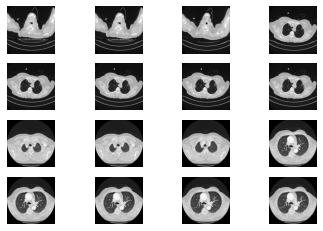

In [10]:
for i, img_path in enumerate(next_covid_pix + next_non_covid_pix):
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis('Off')
    
    img = mpimg.imread(img_path)
    plt.imshow(img,cmap='gray')

plt.show()

### Set up the model and display its architecture

In [14]:
def make_model():
    '''
    Define your model architecture here.
    Returns `Sequential model`
    '''
    
    model = models.Sequential()
    
    model.add(layers.Conv2D(16,(3,3),input_shape=(256,256,3),padding="same"))
    model.add(layers.LeakyReLU(0.1))
#     model.add(layers.Conv2D(32,(3,3),activation = 'relu', padding="same"))

    model.add(layers.Conv2D(32,(3,3), padding="same"))  
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.1))
#     model.add(layers.Dropout(0.25))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(64,(3,3),padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.1))   
#     model.add(layers.Dropout(0.25))
    model.add(layers.MaxPooling2D((2,2)))
    
    model.add(layers.Conv2D(128,(3,3),padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.1))
#     model.add(layers.Dropout(0.1))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(256))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.1))
    model.add(layers.Dropout(0.1))
      

    model.add(layers.Dense(1,activation='sigmoid'))
    
    
    
    return model

In [15]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      4640      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      1

### Set up the model training parameters for loss, optimizer and metrics

In [16]:
model.compile(loss='binary_crossentropy',
             optimizer=RMSprop(learning_rate=0.0001),
             metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

### Training and Vaidation data generator

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(256,256),
            batch_size=32,
            class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
            validation_dir,
            target_size =(256,256),
            batch_size=32,
            class_mode='binary')

Found 335672 images belonging to 2 classes.
Found 75534 images belonging to 2 classes.


### Learning rate scheduler

In [18]:
INIT_LR = 1e-4

In [19]:
# learning rate fraction
lr_frac = 0.7
def lr_scheduler(epoch):
        return INIT_LR * lr_frac ** epoch
# callback for printing of actual learning rate used by optimizer
class LrHistory(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        tf.print(("Learning rate:",model.optimizer.lr))
   

In [22]:
train_generator.reset()
validation_generator.reset()

### Train the model and test on validation set

In [ ]:
history= model.fit(
    train_generator,
    steps_per_epoch=200,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=75,
    verbose=2,
    callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_scheduler),LrHistory()]
    )


### Compute average precision

In [23]:
val_precision = history.history['val_precision']
avg_precision = np.mean(val_precision)
avg_precision

0.7631975849469502

### Compute average recall 

In [24]:
val_recall = history.history['val_recall']
avg_recall = np.mean(val_recall)
avg_recall

0.8497981389363607

### Compute F1 score

In [25]:
F1score = (2*avg_precision*avg_recall)/ (avg_precision + avg_recall)
F1score

0.8041731019189763

### Display loss on training and validation data sets

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']

In [27]:
epochs = range(len(loss))

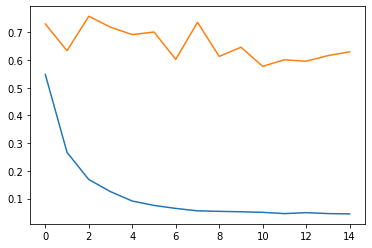

In [28]:
plt.plot(epochs,loss)
plt.plot(epochs,val_loss)

## Test Data Analysis

### Number of test files in different sub folders

In [65]:
totalFiles = 0
totalDir = 0

for base, dirs, files in os.walk(test_dir):
#     print('Searching in : ',base)
    for directories in dirs:
        totalDir += 1
    for Files in files:
        _,ending = os.path.splitext(Files)
        if ending == ".jpg":
            totalFiles += 1


print('Total number of files',totalFiles)
print('Total Number of directories',totalDir)
print('Total:',(totalDir + totalFiles))

Total number of files 609057
Total Number of directories 3463
Total: 612520


In [ ]:
def get_image_names(folder):
    fs = []
    for subdir, dirs, files in os.walk(folder, topdown=True):
        for f in files:
            _,ending = os.path.splitext(f)
            if ending == ".jpg":
                fs.append(os.path.join(subdir,f))
    return(fs)

test_image_list = get_image_names(test_dir)
                
assert(totalFiles==len(test_image_list))  



### Categorical labels of Validation and training data sets

In [86]:
print(validation_generator.class_indices)

{'covid': 0, 'non-covid': 1}


### Data generator for test set

In [89]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = val_datagen.flow_from_directory(
            test_dir,
            target_size =(256,256),
            batch_size=32,
            class_mode='binary',
            shuffle=False)

Found 609057 images belonging to 1 classes.


In [90]:
test_generator.reset()

In [ ]:
# preds = model.predict(test_generator,steps= math.ceil(test_generator.samples//32),workers=8)
preds = model.predict(test_generator,steps= len(test_generator),workers=8,verbose=1)

In [ ]:
# Get class labels
cls = np.round(preds)
file_names = test_generator.filenames

In [ ]:
# Final results in a Data Frame that can be saved in .csv file
results=pd.DataFrame({"file":file_names,"pr":preds[:,0], "class":cls[:,0]})